## Imports

In [578]:
from datetime import datetime, timedelta
import logging
import pandas as pd
import numpy as np

from prometheus_api_client import MetricRangeDataFrame, PrometheusConnect

import sklearn
from sklearn.datasets import fetch_california_housing

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from xgboost import XGBRegressor


from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.utils import Bunch

import matplotlib.pyplot as plt

## Constants

In [579]:
PROM_URL = "http://localhost:9090"
RATE_INTERVAL = "20s"

METRIC_BPF_CPU_TIME = "kepler_process_bpf_cpu_time_ms_total"
QUERY_BPF_CPU_TIME = "sum(rate(kepler_process_bpf_cpu_time_ms_total{}[{}]))"
COLUMNS_COMMAND_PID = ['command', 'pid']

METRIC_CPU_INSTRUCTIONS = "kepler_process_cpu_instructions_total"
QUERY_CPU_INSTRUCTIONS = "sum(rate(kepler_process_cpu_instructions_total{}[{}]))"

METRIC_CPU_CYCLES = "kepler_process_cpu_cycles_total"
QUERY_CPU_CYCLES = "sum(rate(kepler_process_cpu_cycles_total{}[{}]))"

METRIC_PKG_JOULES_TOTAL = "kepler_node_package_joules_total"
QUERY_KEPLER_PKG_JOULES_TOTAL = "sum(rate(kepler_node_package_joules_total{}[{}]))"

METRIC_VM_PKG_JOULES_TOTAL = "kepler_vm_package_joules_total"
QUERY_KEPLER_VM_PKG_JOULES_TOTAL = "sum(rate(kepler_vm_package_joules_total{}[{}]))"

METRIC_VM_CPU_CYCLES_TOTAL = "kepler_vm_cpu_cycles_total"
QUERY_KEPLER_VM_CPU_CYCLES_TOTAL = "sum(rate(kepler_vm_cpu_cycles_total{}[{}]))"

METRIC_VM_CPU_INSTRUCTIONS_TOTAL = "kepler_vm_cpu_instructions_total"
QUERY_KEPLER_VM_CPU_INSTRUCTIONS_TOTAL = "sum(rate(kepler_vm_cpu_instructions_total{}[{}]))"


METRIC_NODE_RAPL_PKG_JOULES_TOTAL = "node_rapl_package_joules_total"
QUERY_NODE_RAPL_PKG_JOULES_TOTAL = "sum(rate(node_rapl_package_joules_total{}[{}]))"
LABEL_RAPL_PATH = "/host/sys/class/powercap/intel-rapl:0"

METRIC_NODE_CPU_SCALING_FREQUENCY_HERTZ = "node_cpu_scaling_frequency_hertz"
QUERY_NODE_CPU_SCALING_FREQUENCY_HERTZ = "sum(node_cpu_scaling_frequency_hertz{})"
LABEL_RAPL_PATH = "/host/sys/class/powercap/intel-rapl:0"

JOB_DEV = {"job":"dev"}
JOB_METAL = {"job":"metal"}
JOB_VM = {"job":"vm"}
JOB_NODE_EXPORTER = {"job":"node-exporter"}
COMMAND_STRESS = {"command": ".*stress.*"}

METRIC_UP = "up"

## Set log level

In [580]:
logging.basicConfig(level=logging.ERROR)

In [581]:
def train_lr(data):
    X = data.drop('PRICE', axis=1)
    y = data['PRICE']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")
    print("Coefficients:")
    for feature, coef in zip(X.columns, model.coef_):
        print(f"{feature}: {coef}")
    return model

In [582]:
def test_california_housing():
    california: Bunch = fetch_california_housing()
    data: pd.DataFrame = pd.DataFrame(california.data, columns=california.feature_names)
    data['PRICE'] = california.target
    print(data.head())
    data.plot()
    plt.show()
    model = train_lr(data)
    return model

In [583]:
def fetch_prometheus_data(start_time, end_time, query, rename_value_column, columns=[], label_config: dict = None):
    try:
        prom = PrometheusConnect(url=PROM_URL, disable_ssl=True)
        if label_config:
            label_list = [str(key + "=~" + "'" + label_config[key] + "'") for key in label_config]
            labels = "{" + ",".join(label_list) + "}"
        else:
            labels = ""

        if "rate(" in query:
            query = query.format(labels, RATE_INTERVAL)
        else:
            query = query.format(labels)

        metric_data = prom.custom_query_range(query=query, start_time=start_time, end_time=end_time, step="1s")
        if not metric_data:
            raise ValueError(f"No data found for metric: {query}")
        #print(metric_data)
        metric_df = MetricRangeDataFrame(data=metric_data, columns=(columns + ['timestamp', 'value']), ts_as_datetime=False)
        metric_df.index = metric_df.index.astype('int64')
        metric_df.rename(columns={'value': rename_value_column}, inplace=True)
        metric_df = metric_df.sort_values(by='timestamp')
        return metric_df
    except Exception as e:
        import traceback
        print(f"An error occurred: {e}")
        traceback.print_exc()
        return pd.DataFrame()

In [584]:
def printDF(df: pd.DataFrame):
    df_name = df.attrs['name']
    print(f"{df_name} shape: {df.shape}, Columns: {df.columns}, Index={df.index}")
    print(df)

## Start and end time

In [585]:
duration_5_min = 1000 * 60 * 5
duration_10_min = 1000 * 60 * 10
duration_20_min = 1000 * 60 * 20
duration_30_min = 1000 * 60 * 30
duration_45_min = 1000 * 60 * 45
duration_1_hour = 1000 * 60 * 60
duration_2_hour = duration_1_hour * 2



end_time = datetime.now()
#end_time = datetime.fromtimestamp(1726759800)


duration = duration_2_hour

start_time = end_time - timedelta(milliseconds=duration)
#start_time = 1726633800
#start_time = datetime.fromtimestamp(1726752600)


## Query prometheus and get the following data frames
 - `bpf_cpu_time_df`: bpf cpu time for all processes, from kepler
 - `rapl_pkg_joules_df` : rapl power from Node Exporter
 - `kepler_pkg_joules_df` : kepler process package joules
 - `cpu_inst_df` : cpu instructions for all processes, from kepler

In [586]:
bpf_cpu_time_df = fetch_prometheus_data(
    start_time=start_time,
    end_time=end_time,
    query=QUERY_BPF_CPU_TIME,
    rename_value_column='bpf_cpu_time',
    label_config=JOB_METAL,
    #columns=COLUMNS_COMMAND_PID
    )
bpf_cpu_time_df.attrs = {"name": "bpf_cpu_time_df"}
#printDF(bpf_cpu_time_df)

In [587]:
rapl_pkg_joules_df = fetch_prometheus_data(
    start_time=start_time,
    end_time=end_time,
    query=QUERY_NODE_RAPL_PKG_JOULES_TOTAL,
    rename_value_column='rapl_pkg_joules',
    label_config=JOB_NODE_EXPORTER)
rapl_pkg_joules_df.attrs = {"name": "rapl_pkg_joules_df"}
#printDF(rapl_pkg_joules_df)

In [588]:
kepler_node_pkg_joules_df = fetch_prometheus_data(
    start_time=start_time,
    end_time=end_time,
    query=QUERY_KEPLER_PKG_JOULES_TOTAL,
    rename_value_column='kepler_node_pkg_joules',
    label_config=JOB_METAL,
    columns=COLUMNS_COMMAND_PID)
kepler_node_pkg_joules_df.attrs = {"name": "kepler_node_pkg_joules_df"}
#printDF(kepler_node_pkg_joules_df)

In [589]:
kepler_vm_pkg_joules_df = fetch_prometheus_data(
    start_time=start_time,
    end_time=end_time,
    query=QUERY_KEPLER_VM_PKG_JOULES_TOTAL,
    rename_value_column='kepler_vm_pkg_joules',
    label_config=JOB_METAL,
    columns=COLUMNS_COMMAND_PID)
kepler_vm_pkg_joules_df.attrs = {"name": "kepler_vm_pkg_joules_df"}
#printDF(kepler_pkg_joules_df)

In [590]:
cpu_inst_df = fetch_prometheus_data(
    start_time=start_time,
    end_time=end_time,
    query=QUERY_CPU_INSTRUCTIONS,
    rename_value_column='cpu_instructions',
    label_config=JOB_METAL,
    columns=COLUMNS_COMMAND_PID)
cpu_inst_df.attrs = {"name": "cpu_inst_df"}
#printDF(cpu_inst_df)

In [591]:
cpu_cycles_df = fetch_prometheus_data(
    start_time=start_time,
    end_time=end_time,
    query=QUERY_CPU_CYCLES,
    rename_value_column='cpu_cycles',
    label_config=JOB_METAL,
    columns=COLUMNS_COMMAND_PID)
cpu_cycles_df.attrs = {"name": "cpu_cycles_df"}    
#printDF(cpu_cycles_df)

In [592]:
cpu_scaling_freq_df = fetch_prometheus_data(
    start_time=start_time,
    end_time=end_time,
    query=QUERY_NODE_CPU_SCALING_FREQUENCY_HERTZ,
    rename_value_column='cpu_scaling_freq',
    label_config=JOB_NODE_EXPORTER,
    columns=COLUMNS_COMMAND_PID)
cpu_scaling_freq_df.attrs = {"name": "cpu_scaling_freq_df"}    
#printDF(cpu_scaling_freq_df)

## Scale by num of CPUs

In [593]:
num_cpus = 16

bpf_cpu_time_df['bpf_cpu_time'] = bpf_cpu_time_df['bpf_cpu_time'] / num_cpus
cpu_inst_df['cpu_instructions'] = cpu_inst_df['cpu_instructions'] / num_cpus
cpu_cycles_df['cpu_cycles'] = cpu_cycles_df['cpu_cycles'] / num_cpus

rapl_pkg_joules_df['rapl_pkg_joules'] = rapl_pkg_joules_df['rapl_pkg_joules'] / num_cpus


## Sample values

In [594]:
bpf_cpu_time_df.head()

,bpf_cpu_time
timestamp,
1727080940,91.632765
1727080941,91.696411
1727080942,91.760057
1727080943,91.812819
1727080944,91.854583


In [595]:
rapl_pkg_joules_df.head()

,rapl_pkg_joules
timestamp,
1727080940,1.194800
1727080941,1.194800
1727080942,1.194800
1727080943,1.403994
1727080944,1.403994


## Plot 'em

<Axes: xlabel='timestamp'>

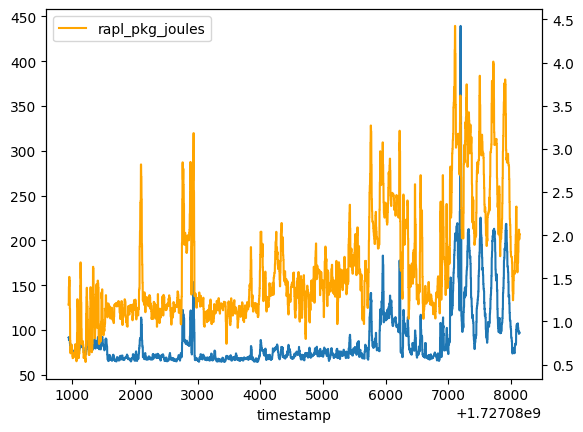

In [596]:
ax = bpf_cpu_time_df['bpf_cpu_time'].plot(label='bpf_cpu_time')
ax2 = ax.twinx()
rapl_pkg_joules_df.plot(ax = ax2, color='orange', label='rapl_pkg_joules')
#kepler_pkg_joules_df.plot(ax = ax2, color='green', label='kepler_pkg_joules')

<Axes: xlabel='timestamp'>

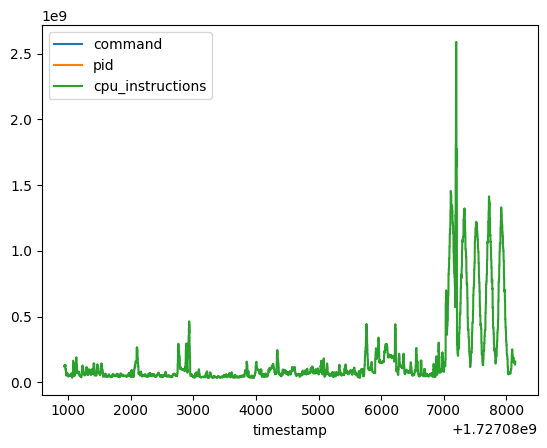

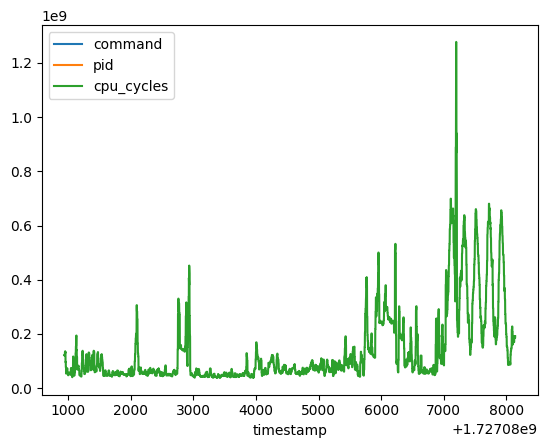

In [597]:
cpu_inst_df.plot()
cpu_cycles_df.plot()
#cpu_scaling_freq_df
#plt.show()

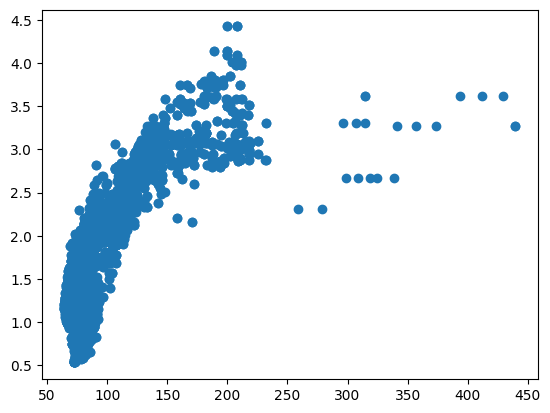

In [598]:
plt.scatter(x = bpf_cpu_time_df['bpf_cpu_time'], y = rapl_pkg_joules_df['rapl_pkg_joules'])

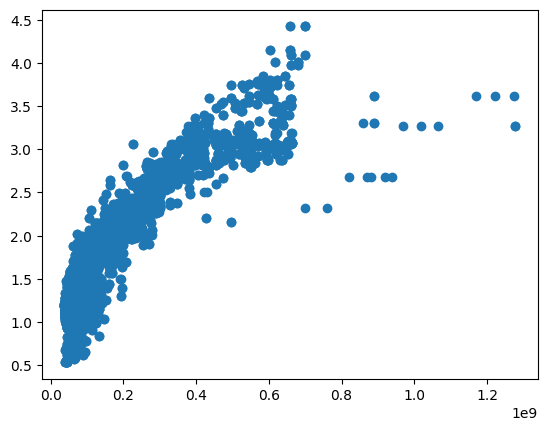

In [599]:
plt.scatter(x = cpu_cycles_df['cpu_cycles'], y = rapl_pkg_joules_df['rapl_pkg_joules'])

# Prepare input data for training

In [600]:
#X = pd.DataFrame(bpf_cpu_time_df['bpf_cpu_time'], cpu_inst_df['cpu_instructions'])
#X = bpf_cpu_time_df.drop(['command', 'pid', 'bpf_cpu_time_ratio'], axis =1)
X = bpf_cpu_time_df
X['cpu_instructions'] = cpu_inst_df['cpu_instructions']
X['cpu_cycles'] = cpu_cycles_df['cpu_cycles']
#X['cpu_scaling_freq'] = cpu_scaling_freq_df['cpu_scaling_freq']
y = pd.DataFrame(rapl_pkg_joules_df['rapl_pkg_joules'])

In [601]:
X.sample

<bound method NDFrame.sample of             bpf_cpu_time  cpu_instructions    cpu_cycles
timestamp                                               
1727080940     91.632765      1.267075e+08  1.217711e+08
1727080941     91.696411      1.269580e+08  1.220145e+08
1727080942     91.760057      1.272086e+08  1.222578e+08
1727080943     91.812819      1.274050e+08  1.224005e+08
1727080944     91.854583      1.276074e+08  1.225599e+08
...                  ...               ...           ...
1727088136     97.554167      1.351730e+08  1.849404e+08
1727088137     97.554167      1.351730e+08  1.849404e+08
1727088138     97.554167      1.351730e+08  1.849404e+08
1727088139     97.554167      1.351730e+08  1.849404e+08
1727088140     97.145754      1.563224e+08  1.909387e+08

[7201 rows x 3 columns]>

In [602]:
X.columns

Index(['bpf_cpu_time', 'cpu_instructions', 'cpu_cycles'], dtype='object')

In [603]:
X.shape

(7201, 3)

In [604]:
y.sample

<bound method NDFrame.sample of             rapl_pkg_joules
timestamp                  
1727080940         1.194800
1727080941         1.194800
1727080942         1.194800
1727080943         1.403994
1727080944         1.403994
...                     ...
1727088136         1.952269
1727088137         1.952269
1727088138         2.012518
1727088139         2.012518
1727088140         2.012518

[7201 rows x 1 columns]>

# Split into training and test data

In [605]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.columns)
X_train.sample

Index(['bpf_cpu_time', 'cpu_instructions', 'cpu_cycles'], dtype='object')


<bound method NDFrame.sample of             bpf_cpu_time  cpu_instructions    cpu_cycles
timestamp                                               
1727086950     80.362500      1.003341e+08  1.217528e+08
1727083990     71.272258      7.556683e+07  7.311815e+07
1727083148     67.970833      4.173418e+07  4.491583e+07
1727082363     73.395833      6.290167e+07  7.153586e+07
1727081062     73.604167      4.228741e+07  4.551044e+07
...                  ...               ...           ...
1727084712     71.004167      5.671798e+07  5.571213e+07
1727086131    110.075000      2.115431e+08  2.608705e+08
1727086166    108.708333      1.853353e+08  2.381690e+08
1727086330     93.266667      1.083949e+08  1.765280e+08
1727081800     68.183333      4.055362e+07  4.631518e+07

[5760 rows x 3 columns]>

# Train Models and test

## Linear Regression

In [606]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"MAPE: {mape}")
print("Coefficients:")
for feature, coef in zip(X.columns, lr_model.coef_):
    print(f"{feature}: {coef}")

Mean Squared Error: 0.026387819537861304
R^2 Score: 0.9442793374318664
MAPE: 9.087043139504548
Coefficients:
bpf_cpu_time: [-4.12595873e-02 -5.24480872e-10  1.48680145e-08]


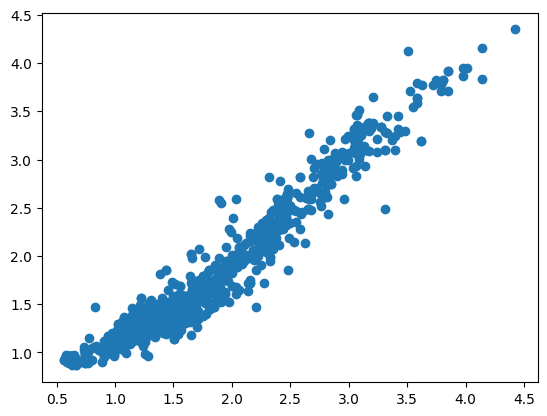

In [607]:
plt.scatter(x = y_test, y = y_pred)

## Polynomial Regression

In [608]:
poly = PolynomialFeatures(degree=2)
pr_model = make_pipeline(poly, LinearRegression())
pr_model.fit(X_train, y_train)

y_pred = pr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100


print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"MAPE: {mape}")

#print(model)
#print("Coefficients:")
#for feature, coef in zip(X.columns, model.coef_):
#    print(f"{feature}: {coef}")


Mean Squared Error: 0.021568029504972587
R^2 Score: 0.954456832153873
MAPE: 7.452363643783749


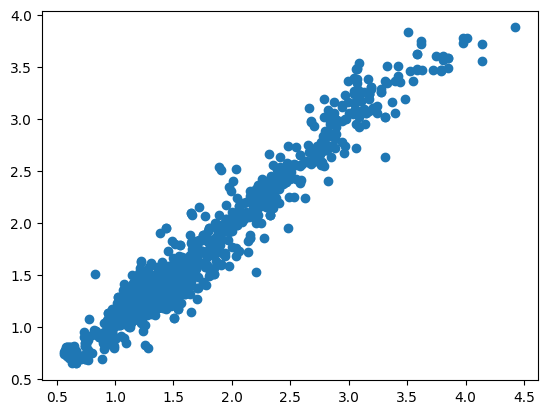

In [609]:
plt.scatter(x = y_test, y = y_pred)

##  Logarithmic Transformation

In [610]:
# Apply log transformation to the target variable
X_train_log = np.log(X_train)

# Fit a Linear Regression model
lt_model = LinearRegression()
lt_model.fit(X_train_log, y_train)

# Predict and reverse log transformation
X_test_log = np.log(X_test)
y_pred = lt_model.predict(X_test_log)
#y_pred_log = lt_model.predict(X_test)
#y_pred = np.exp(y_pred_log)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100


print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"MAPE: {mape}")




Mean Squared Error: 0.06078687204730816
R^2 Score: 0.8716421119577322
MAPE: 14.55819867601008


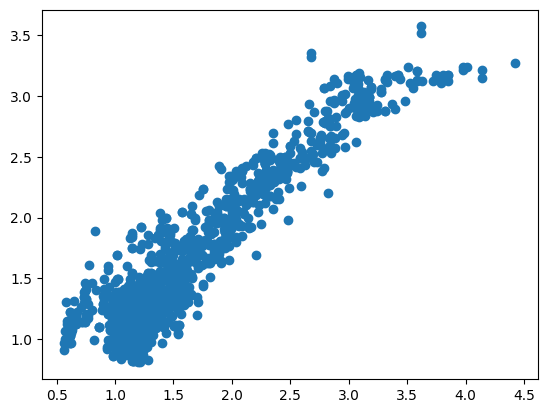

In [611]:
plt.scatter(x = y_test, y = y_pred)

## Decision Trees

In [612]:
dt_model = DecisionTreeRegressor(max_depth=5)  # Tune depth as necessary
dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100


print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"MAPE: {mape}")


Mean Squared Error: 0.02766792637655085
R^2 Score: 0.9415762569023275
MAPE: 8.537391256126451


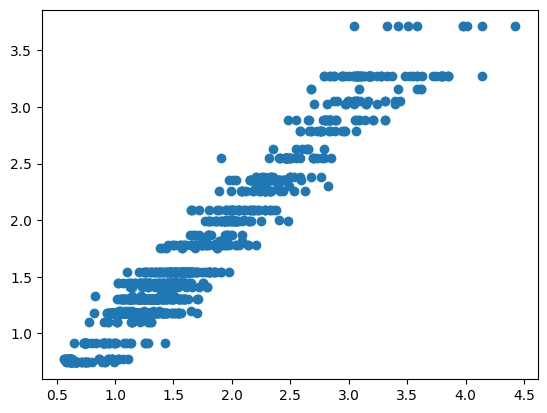

In [613]:
plt.scatter(x = y_test, y = y_pred)

## Random Forests

In [614]:
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100


print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"MAPE: {mape}")


/home/vimalkum/src/github/vimalk78/power-train/.power-model/lib64/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Squared Error: 0.009294575405509542
R^2 Score: 0.9803735242640497
MAPE: 4.072044996221952


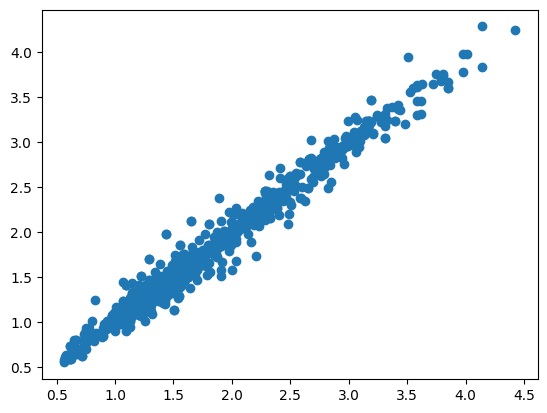

In [615]:
plt.scatter(x = y_test, y = y_pred)

##  Gradient Boosting (XGBoost)

In [616]:
gb_model = XGBRegressor()
gb_model.fit(X_train, y_train)

y_pred = gb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100


print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"MAPE: {mape}")


Mean Squared Error: 0.01155422571011588
R^2 Score: 0.9756020307540894
MAPE: 4.681355202894533


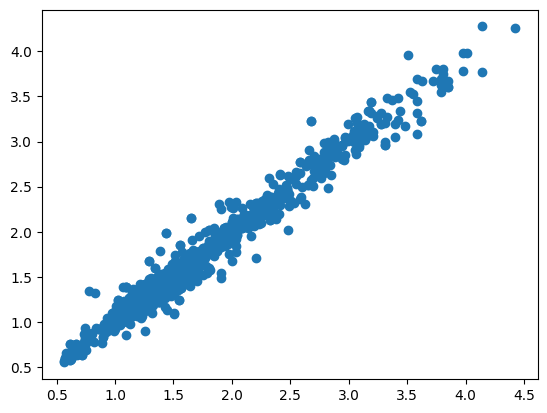

In [617]:
plt.scatter(x = y_test, y = y_pred)

## Support Vector Regression (SVR)

In [618]:
svr_model = SVR(kernel='rbf')  # Try 'poly' for polynomial kernel
svr_model.fit(X_train, y_train)

y_pred = svr_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100


print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"MAPE: {mape}")


/home/vimalkum/src/github/vimalk78/power-train/.power-model/lib64/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error: 0.050670810149611445
R^2 Score: 0.893003243017127
MAPE: 13.134490633984491


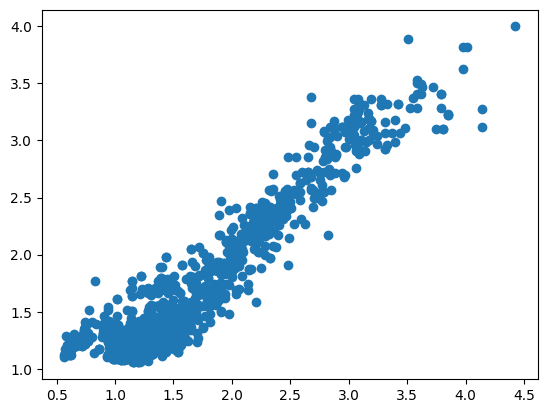

In [619]:
plt.scatter(x = y_test, y = y_pred)

# Model Validation

## Set validation start and end time

In [657]:
#validation_end_time = datetime.now()
end_time = datetime.fromtimestamp(1727088375)

validation_duration = duration_30_min

validation_start_time = validation_end_time - timedelta(milliseconds=validation_duration)

In [658]:
print(f"start: {validation_start_time}")
print(f"end  : {validation_end_time}")

start: 2024-09-23 15:46:14.599322
end  : 2024-09-23 16:16:14.599322


## Validation on vm bpf cpu time

### Fetch new data

In [659]:
vm_bpf_cpu_time_df = fetch_prometheus_data(
    start_time=validation_start_time,
    end_time=validation_end_time,
    query=QUERY_BPF_CPU_TIME,
    rename_value_column='bpf_cpu_time',
    label_config=JOB_VM,    
    #columns=COLUMNS_COMMAND_PID
    )
vm_bpf_cpu_time_df.attrs = {"name": "vm_bpf_cpu_time_df"}
#printDF(vm_bpf_cpu_time_df)

In [660]:
rapl_pkg_joules_df = fetch_prometheus_data(
    start_time=validation_start_time,
    end_time=validation_end_time,
    query=QUERY_NODE_RAPL_PKG_JOULES_TOTAL,
    rename_value_column='rapl_pkg_joules',
    label_config=JOB_NODE_EXPORTER|{"path": LABEL_RAPL_PATH})
rapl_pkg_joules_df.attrs = {"name": "rapl_pkg_joules_df"}
#printDF(rapl_pkg_joules_df)

In [661]:
kepler_pkg_joules_df = fetch_prometheus_data(
    start_time=validation_start_time,
    end_time=validation_end_time,
    query=QUERY_KEPLER_PKG_JOULES_TOTAL,
    rename_value_column='kepler_pkg_joules',
    label_config=JOB_METAL,        
    columns=COLUMNS_COMMAND_PID)
kepler_pkg_joules_df.attrs = {"name": "kepler_pkg_joules_df"}
#printDF(kepler_pkg_joules_df)

In [662]:
vm_pkg_joules_df = fetch_prometheus_data(
    start_time=validation_start_time,
    end_time=validation_end_time,
    query=QUERY_KEPLER_VM_PKG_JOULES_TOTAL,
    rename_value_column='vm_pkg_joules',
    label_config=JOB_METAL)
vm_pkg_joules_df.attrs = {"name": "vm_pkg_joules_df"}
#printDF(vm_pkg_joules_df)

In [663]:
vm_cpu_inst_df = fetch_prometheus_data(
    start_time=validation_start_time,
    end_time=validation_end_time,
    query=QUERY_CPU_INSTRUCTIONS,
    rename_value_column='vm_cpu_instructions',
    label_config=JOB_METAL,        
    columns=COLUMNS_COMMAND_PID)
vm_cpu_inst_df.attrs = {"name": "vm_cpu_inst_df"}
#printDF(vm_cpu_inst_df)

In [664]:
vm_cpu_cycles_df = fetch_prometheus_data(
    start_time=validation_start_time,
    end_time=validation_end_time,
    query=QUERY_CPU_CYCLES,
    rename_value_column='vm_cpu_cycles',
    label_config=JOB_METAL,            
    columns=COLUMNS_COMMAND_PID)
vm_cpu_cycles_df.attrs = {"name": "vm_cpu_cycles_df"}    
#printDF(vm_cpu_cycles_df)

In [665]:
cpu_scaling_freq_df = fetch_prometheus_data(
    start_time=validation_start_time,
    end_time=validation_end_time,
    query=QUERY_NODE_CPU_SCALING_FREQUENCY_HERTZ,
    rename_value_column='cpu_scaling_freq',
    label_config=JOB_NODE_EXPORTER,            
    columns=COLUMNS_COMMAND_PID)
cpu_scaling_freq_df.attrs = {"name": "cpu_scaling_freq_df"}    
#printDF(cpu_scaling_freq_df)

### Scale by num of cpus

In [666]:
num_vcpus = 2

In [667]:
vm_bpf_cpu_time_df['bpf_cpu_time'] = vm_bpf_cpu_time_df['bpf_cpu_time'] / 20
vm_cpu_inst_df['vm_cpu_instructions'] = vm_cpu_inst_df['vm_cpu_instructions'] / num_vcpus
vm_cpu_cycles_df['vm_cpu_cycles'] = vm_cpu_cycles_df['vm_cpu_cycles'] / num_vcpus

### prepare vm validation data

In [668]:
X = vm_bpf_cpu_time_df
X['cpu_instructions'] = vm_cpu_inst_df['vm_cpu_instructions']
X['cpu_cycles'] = vm_cpu_cycles_df['vm_cpu_cycles']
#X['cpu_scaling_freq'] = cpu_scaling_freq_df['cpu_scaling_freq']

In [669]:
#print(bpf_cpu_time_df.shape)
#bpf_cpu_time_df.sample

In [670]:
X.sample

<bound method NDFrame.sample of             bpf_cpu_time  cpu_instructions    cpu_cycles
timestamp                                               
1727086575     50.140000      1.278629e+09  1.592179e+09
1727086576     50.140000      1.278629e+09  1.592179e+09
1727086577     50.086667      1.278629e+09  1.592179e+09
1727086578     50.086667      1.278629e+09  1.592179e+09
1727086579     50.086667      1.278629e+09  1.592179e+09
...                  ...               ...           ...
1727088371     50.106667      1.043143e+09  1.576723e+09
1727088372     50.290000      1.043143e+09  1.576723e+09
1727088373     50.290000      1.043143e+09  1.576723e+09
1727088374     50.290000      1.043143e+09  1.576723e+09
1727088375     50.290000      1.078465e+09  1.649385e+09

[1801 rows x 3 columns]>

In [671]:
vm_pkg_joules_df.sample

<bound method NDFrame.sample of             vm_pkg_joules
timestamp                
1727086575         0.1588
1727086576         0.1588
1727086577         0.1588
1727086578         0.1588
1727086579         0.1588
...                   ...
1727088371         0.1130
1727088372         0.1130
1727088373         0.1130
1727088374         0.1130
1727088375         0.1358

[1801 rows x 1 columns]>

### Run Validations

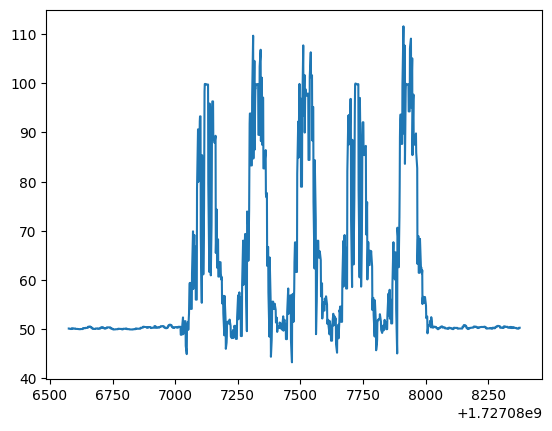

Model : LinearRegression
Mean Squared Error (MSE)         : 5460.421742002494
Mean Abs percentage Error (MAPE) : 16601.271003226557
R^2 Score                        : -343.1703518156142
Correlation        : 0.833801


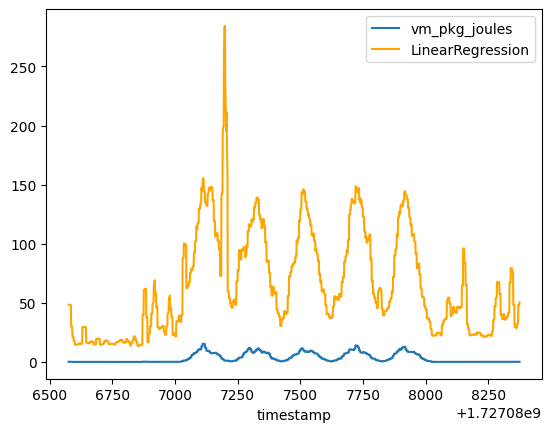

Model : PolynomialRegression
Mean Squared Error (MSE)         : 1577925.2454183877
Mean Abs percentage Error (MAPE) : 68988.39110460418
R^2 Score                        : -99455.61938105618
Correlation        : -0.676892


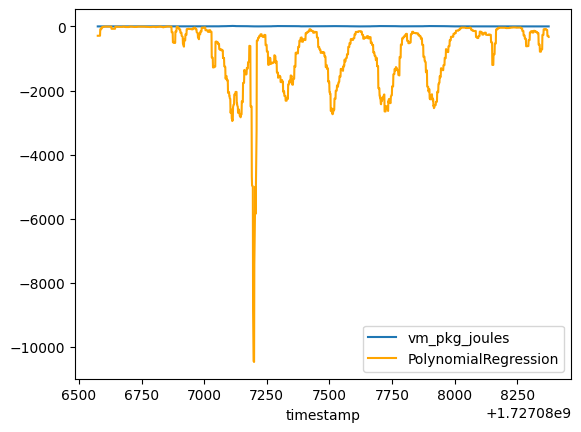

Model : XGBoost
Mean Squared Error (MSE)         : 44.54901420970805
Mean Abs percentage Error (MAPE) : 4656.0045046103605
R^2 Score                        : -1.8079241161271846
Correlation        : 0.469153


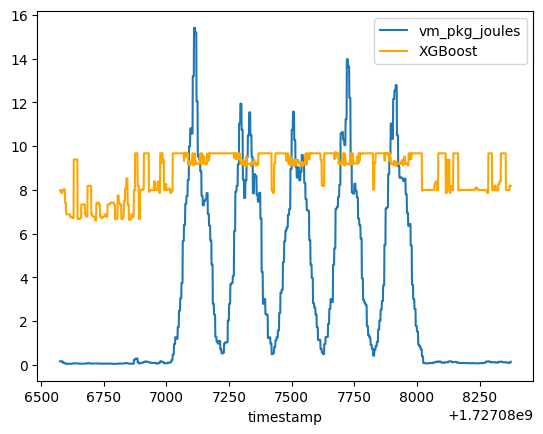

In [672]:
trained_models = {"LinearRegression":lr_model}|{"PolynomialRegression":pr_model}|{"DecisionTree":dt_model}|{"RandomForest":rf_model}|{"XGBoost":gb_model}|{"SVR":svr_model}|{"LogarithmicTransformation":lt_model}
test_models = {"LinearRegression":lr_model}|{"PolynomialRegression":pr_model}|{"XGBoost":gb_model}


plt.plot(X['bpf_cpu_time'])
plt.show()

for model_name, model in test_models.items():
    ax = vm_pkg_joules_df['vm_pkg_joules'].plot(legend="vm_pkg_joules")
    #ax2 = ax.twinx()
    
    x_test = X
    print(f"Model : {model_name}")
    if model_name == "LogarithmicTransformation":
        x_test = np.log(X)
    y_pred = model.predict(x_test)
    y_pred = y_pred * num_vcpus
    mse = mean_squared_error(vm_pkg_joules_df['vm_pkg_joules'], y_pred)
    r2 = r2_score(vm_pkg_joules_df['vm_pkg_joules'], y_pred)
    mape = mean_absolute_percentage_error(vm_pkg_joules_df['vm_pkg_joules'], y_pred) * 100

    
    
    print(f"Mean Squared Error (MSE)         : {mse}")
    print(f"Mean Abs percentage Error (MAPE) : {mape}")    
    print(f"R^2 Score                        : {r2}")    
    df = pd.DataFrame(y_pred, index=vm_pkg_joules_df.index, columns=[model_name])
    corr = df.corrwith(vm_pkg_joules_df['vm_pkg_joules'])   
    corr_value = corr[model_name]
    print(f"Correlation        : {corr_value:4f}")
    
    df.plot(ax = ax, color="orange", legend=model_name)


    plt.legend()
    plt.show()

Model : LinearRegression
Mean Squared Error (MSE)         : 3658.3405441099953
Mean Abs percentage Error (MAPE) : 222.55954303294624
R^2 Score                        : -94.28344574865564
Correlation        : 0.909034


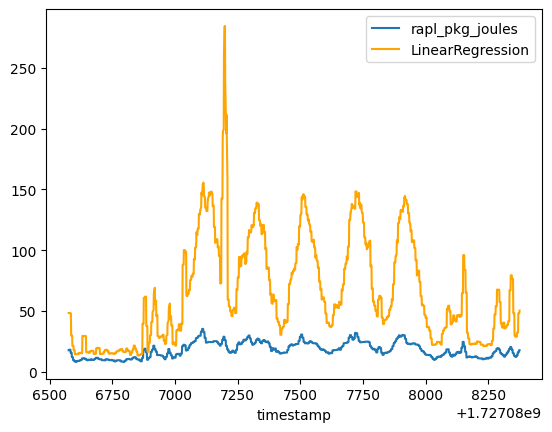

Model : PolynomialRegression
Mean Squared Error (MSE)         : 1604291.8344917768
Mean Abs percentage Error (MAPE) : 3250.2134678058715
R^2 Score                        : -41783.64310079612
Correlation        : -0.746816


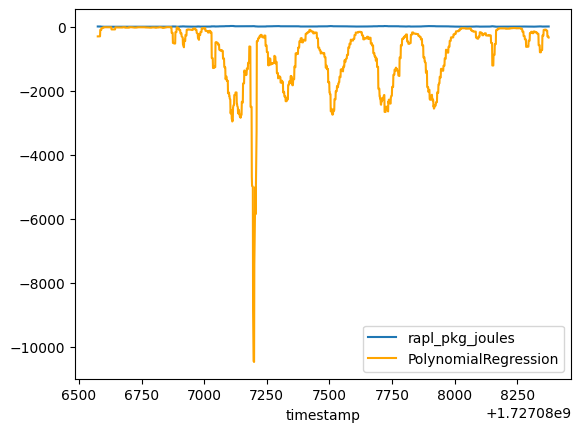

Model : XGBoost
Mean Squared Error (MSE)         : 118.23701934156286
Mean Abs percentage Error (MAPE) : 46.782121931662004
R^2 Score                        : -2.079546718539666
Correlation        : 0.691836


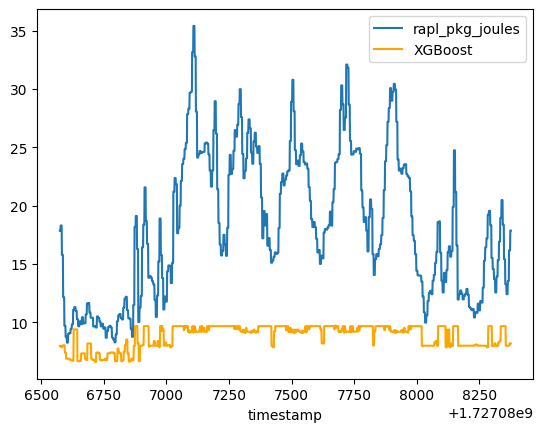

In [673]:
trained_models = {"LinearRegression":lr_model}|{"PolynomialRegression":pr_model}|{"DecisionTree":dt_model}|{"RandomForest":rf_model}|{"XGBoost":gb_model}|{"SVR":svr_model}|{"LogarithmicTransformation":lt_model}
test_models = {"LinearRegression":lr_model}|{"PolynomialRegression":pr_model}|{"XGBoost":gb_model}

for model_name, model in test_models.items():
    ax = rapl_pkg_joules_df['rapl_pkg_joules'].plot(legend="rapl_pkg_joules")
    #ax2 = ax.twinx()
    
    x_test = X
    print(f"Model : {model_name}")
    if model_name == "LogarithmicTransformation":
        x_test = np.log(X)
    y_pred = model.predict(x_test)
    y_pred = y_pred * num_vcpus
    mse = mean_squared_error(rapl_pkg_joules_df['rapl_pkg_joules'], y_pred)
    r2 = r2_score(rapl_pkg_joules_df['rapl_pkg_joules'], y_pred)
    mape = mean_absolute_percentage_error(rapl_pkg_joules_df['rapl_pkg_joules'], y_pred) * 100

    
    
    print(f"Mean Squared Error (MSE)         : {mse}")
    print(f"Mean Abs percentage Error (MAPE) : {mape}")    
    print(f"R^2 Score                        : {r2}")    
    df = pd.DataFrame(y_pred, index=rapl_pkg_joules_df.index, columns=[model_name])
    corr = df.corrwith(rapl_pkg_joules_df['rapl_pkg_joules'])   
    corr_value = corr[model_name]
    print(f"Correlation        : {corr_value:4f}")
    
    df.plot(ax = ax, color="orange", legend=model_name)


    plt.legend()
    plt.show()